# **Multiclass Classification**

**Goal**: Using images of crop diseases from Uganda to build a convolutional neural network and train it to classify images into one of the five classes.

**Objectives**
- Convert images from grayscale to RGB
- Resize images 
- Normalize data
- Create a transformation pipeline to standardize images for training
- create a Convolutional Neural Network
- Train the network to do multiclass classification
- Identify overfitting. 

In [1]:
import os

import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np 
import PIL 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchinfo 
import torchvision 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split 
from torchinfo import summary 
from torchvision import datasets, transforms 
from tqdm import tqdm

In [2]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("PIL version : ", PIL.__version__)

!python --version

torch version :  2.5.1+cpu
torchvision version :  0.20.1+cpu
torchinfo version :  1.8.0
numpy version :  1.26.3
matplotlib version :  3.8.3
PIL version :  10.2.0
Python 3.12.1


In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


**1. Exploring Data**

In [4]:
data_dir = os.path.join("data_p2", "data_undersampled")
train_dir = os.path.join(data_dir, "train")

print("Data Directory:", data_dir)
print("Training Data Directory:", train_dir)

Data Directory: data_p2\data_undersampled
Training Data Directory: data_p2\data_undersampled\train


A list of class names:

In [5]:
classes = os.listdir(train_dir)

print("List of classes:", classes)

List of classes: ['cassava-bacterial-blight-cbb', 'cassava-brown-streak-disease-cbsd', 'cassava-green-mottle-cgm', 'cassava-healthy', 'cassava-mosaic-disease-cmd']


Custom Transformation:

In [6]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

Normalization:

In [7]:
# Define transformation to apply to the images
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        # Convert images to tensors
        transforms.ToTensor(),
        # Normalize the tensors (copy the mean and std from previous lesson!)
        transforms.Normalize(
            mean = [0.4326, 0.4953, 0.3120], std = [0.2178, 0.2214, 0.2091]
        )
        
    ]
)

print(type(transform_normalized))
print("-----------------")
print(transform_normalized)

<class 'torchvision.transforms.transforms.Compose'>
-----------------
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.4326, 0.4953, 0.312], std=[0.2178, 0.2214, 0.2091])
)


In [8]:
dataset = datasets.ImageFolder(root=train_dir, transform= transform_normalized)

print('Length of dataset:', len(dataset))

Length of dataset: 8180


**2. Train and validation splitting**

In [9]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2], generator=g)

print("Length of training dataset:", len(train_dataset))
print("Length of validation dataset:", len(val_dataset))

Length of training dataset: 6544
Length of validation dataset: 1636


In [10]:
length_dataset = len(dataset)
length_train = len(train_dataset)
length_val = len(val_dataset)

percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


Use class_counts function on the entire dataset and visualize the results with a bar chart:

  0%|          | 0/8180 [00:00<?, ?it/s]

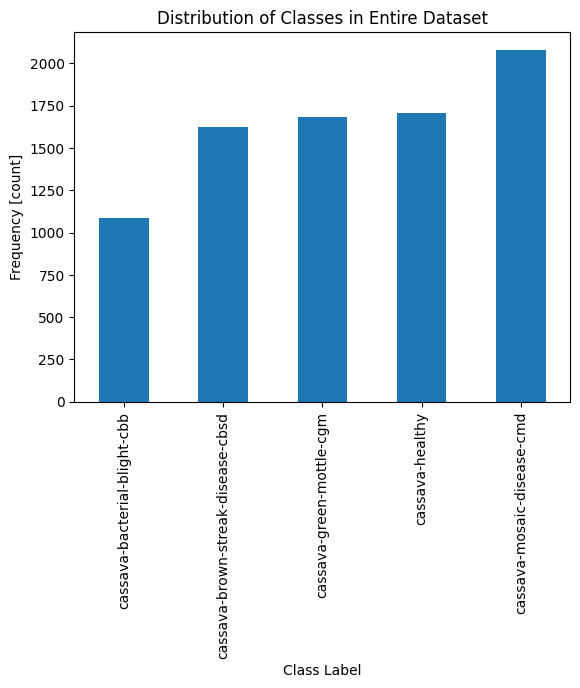

In [11]:
from training import class_counts

dataset_counts = class_counts(dataset)

# Make a bar chart from the function output
dataset_counts.sort_values().plot(kind="bar")
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Entire Dataset");

  0%|          | 0/6544 [00:00<?, ?it/s]

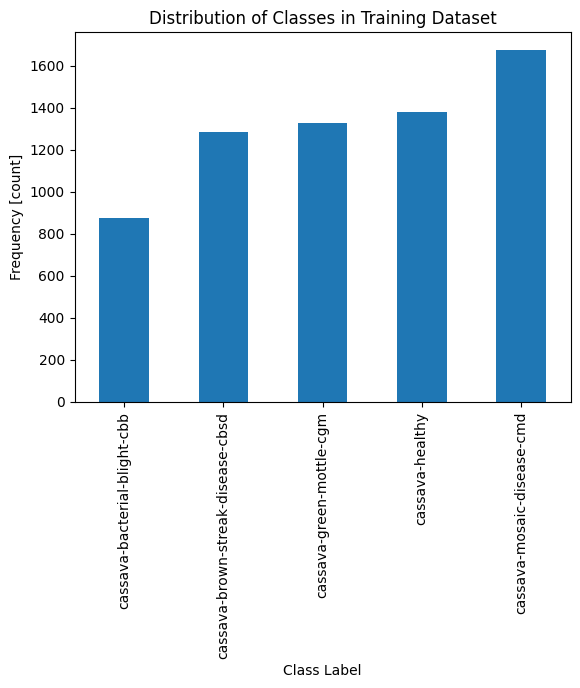

In [12]:
train_counts = class_counts(train_dataset)

# Make a bar chart from the function output
train_counts.sort_values().plot(kind="bar")

# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Training Dataset");

  0%|          | 0/1636 [00:00<?, ?it/s]

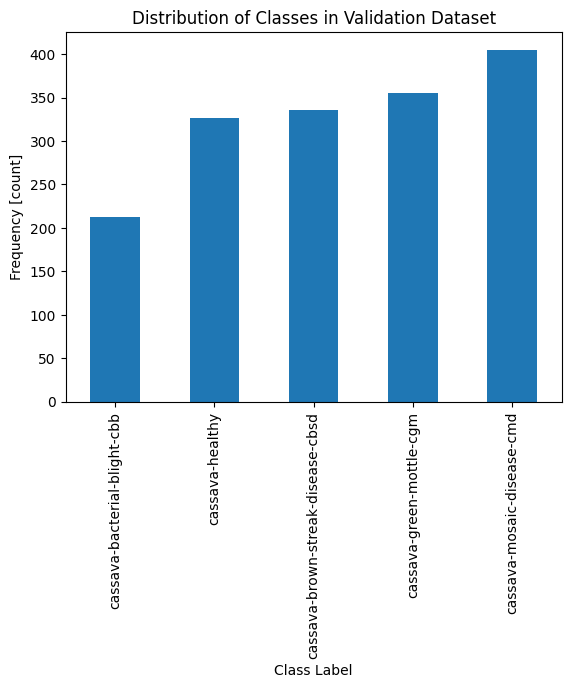

In [13]:
val_counts = class_counts(val_dataset)

# Make a bar chart from the function output
val_counts.sort_values().plot(kind="bar")
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Classes in Validation Dataset");

Data Loader objects:

In [14]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [15]:
val_loader = DataLoader(val_dataset, batch_size)

print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


 Print the shape of a batch of images and the shape of a batch of labels.

In [16]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

image_shape = images.shape
print("Shape of batch of images", image_shape)

label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 224, 224])
Shape of batch of labels: torch.Size([32])


In [17]:
labels

tensor([2, 4, 1, 1, 1, 1, 2, 3, 0, 2, 2, 1, 4, 0, 4, 4, 3, 4, 0, 4, 0, 4, 4, 1,
        2, 0, 2, 1, 4, 4, 4, 4])

**3. Building a Convolutional Neural Networ**

In [18]:
model = torch.nn.Sequential()

conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding = 1)
model.append(conv1)
max_pool1 = nn.MaxPool2d(2, 2)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
max_pool2 = nn.MaxPool2d(2, 2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
max_pool3 = nn.MaxPool2d(2, 2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(nn.Dropout(0.5))

linear1 = torch.nn.Linear(64 * 28 * 28, 500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 5)
model.append(output_layer)

print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)


**4. Training the Mode**

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

print(loss_fn)
print("----------------------")
print(optimizer)

CrossEntropyLoss()
----------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [20]:
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=5, bias=True)
)

In [21]:
height = 224
width = 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 5]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [22]:
from training import train

In [ ]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train(
    model, optimizer, loss_fn, train_loader, val_loader, epochs=15, device=device)

Training:   0%|          | 0/205 [00:00<?, ?it/s]

In [ ]:
df = pd.read_csv('post_train_evaluation_metrics.csv')

In [ ]:
train_losses = df['Train Loss']
valid_losses = df['Validation Loss']

train_accuracies = df['Train Accuracy']
valid_accuracies = df['Validation Accuracy']

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

Mitigating Overfitting: